# Non-cartesian meshes

FESTIM can run simulations in cylindrical or spherical coordinates.

This is extremely useful to simulate axisymmetric systems. Here we show two examples with a pipe and a sphere.

The cylindrical system of coordinates can be applied to 1D and 2D domains.
The spherical system of coordinates can only be applied to 1D domains.

## Pipe

The first example is a 1D axisymmetric simulation representing a pipe.

In [1]:
import festim as F
import numpy as np

my_model = F.Simulation()

Cylindrical coordinates can be set in the ``type`` argument of ``Mesh``:

In [2]:
inner_radius = 0.1e-2
thickness = 0.2e-2
my_model.mesh = F.MeshFromVertices(
    np.linspace(inner_radius, inner_radius + thickness, num=100),
    type="cylindrical",
)

We'll use HTM data for the properties of steel:

In [3]:
import h_transport_materials as htm

steel_D = htm.diffusivities.filter(material=htm.Steel).mean()
steel_S = htm.solubilities.filter(material=htm.Steel).mean()
steel = F.Material(
    id=1,
    D_0=steel_D.pre_exp.magnitude,
    E_D=steel_D.act_energy.magnitude,
    S_0=steel_S.pre_exp.magnitude,
    E_S=steel_S.act_energy.magnitude,
)

my_model.materials = steel

We set a Sievert's boundary condition at the inner surface and a $c=0$ boundary condition at the outer surface.

In [4]:
my_model.boundary_conditions = [
    F.SievertsBC(surfaces=[1], S_0=steel.S_0, E_S=steel.E_S, pressure=1e5),
    F.DirichletBC(surfaces=[2], value=0, field="solute"),
]

**Note**: at the moment, `AverageVolume` and `TotalVolume` are not implemented for non-cartesian coordinates (see [Issue #723](https://github.com/festim-dev/FESTIM/issues/723))

In [5]:
my_model.T = 500

my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    final_time=10000,
)

my_model.dt = F.Stepsize(10, stepsize_change_ratio=1.1)

derived_quantities = F.DerivedQuantities(
    [
        F.SurfaceFluxCylindrical(field="solute", surface=1),
        F.SurfaceFluxCylindrical(field="solute", surface=2),
    ],
    show_units=True,
)

txt_export = F.TXTExport(field="solute", filename="task14/solute.txt")

my_model.exports = [derived_quantities, txt_export]

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+04 s    Elapsed time so far: 0.4 s


/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/remidm/miniconda3/envs/festim-workshop/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


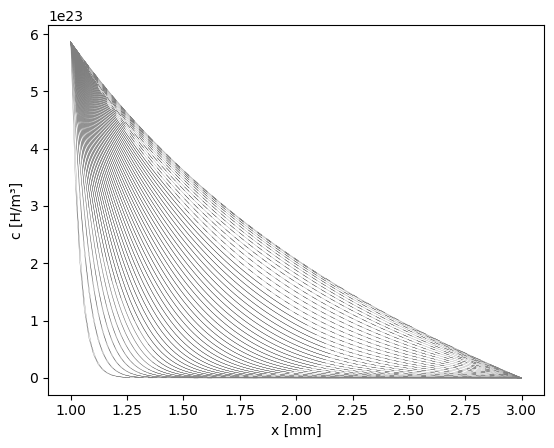

In [6]:
import matplotlib.pyplot as plt

data = np.genfromtxt("task14/solute.txt", skip_header=1, delimiter=",")
for i in range(1, data.shape[1]):
    plt.plot(data[:, 0]/1e-3, data[:, i], color="tab:grey", linewidth=0.2)

plt.xlabel("x [mm]")
plt.ylabel("c [H/m³]")
plt.show()

The surface flux is computed for a full angular coverage by default. The units of the surface flux is H/m/s (per unit height).

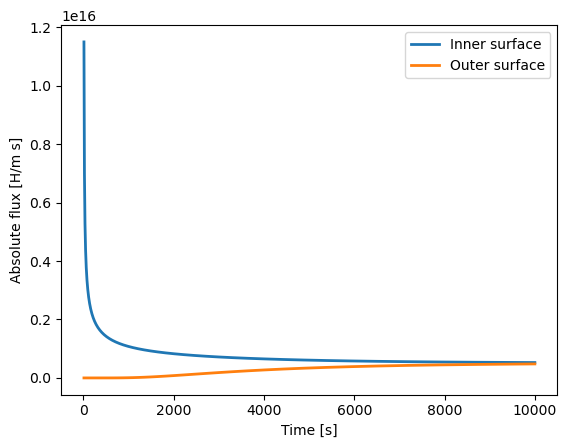

In [7]:
plt.plot(
    derived_quantities[0].t,
    np.abs(derived_quantities[0].data),
    linewidth=2,
    label="Inner surface",
)

plt.plot(
    derived_quantities[1].t,
    np.abs(derived_quantities[1].data),
    linewidth=2,
    label="Outer surface",
)

plt.xlabel("Time [s]")
plt.ylabel("Absolute flux [H/m s]")
plt.legend()
plt.show()

## Sphere

The second example is a plain tungsten sphere of radius 0.1 mm. Similarly we can set the system of coordinates to spherical.

In [8]:
my_model = F.Simulation()

radius = 1e-4
my_model.mesh = F.MeshFromVertices(
    np.linspace(0, radius, num=100),
    type="spherical",
)

tungsten_D = htm.diffusivities.filter(material=htm.Tungsten).mean()
tungsten_S = htm.solubilities.filter(material=htm.Tungsten).mean()
tungsten = F.Material(
    id=1,
    D_0=tungsten_D.pre_exp.magnitude,
    E_D=tungsten_D.act_energy.magnitude,
    S_0=tungsten_S.pre_exp.magnitude,
    E_S=tungsten_S.act_energy.magnitude,
)

my_model.materials = tungsten

my_model.boundary_conditions = [
    F.SievertsBC(surfaces=[2], S_0=tungsten.S_0, E_S=tungsten.E_S, pressure=1e5),
]

my_model.T = 800

my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    final_time=100,
)

my_model.dt = F.Stepsize(1, stepsize_change_ratio=1.1)


The spherical equivalent class of ``SurfaceFlux`` is ``SurfaceFluxSpherical``:

In [9]:
derived_quantities = F.DerivedQuantities(
    [
        F.SurfaceFluxSpherical(field="solute", surface=2),
    ],
    show_units=True,
)

txt_export = F.TXTExport(field="solute", filename="task14/solute_spherical.txt")

my_model.exports = [derived_quantities, txt_export]

In [10]:
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Elapsed time so far: 0.2 s


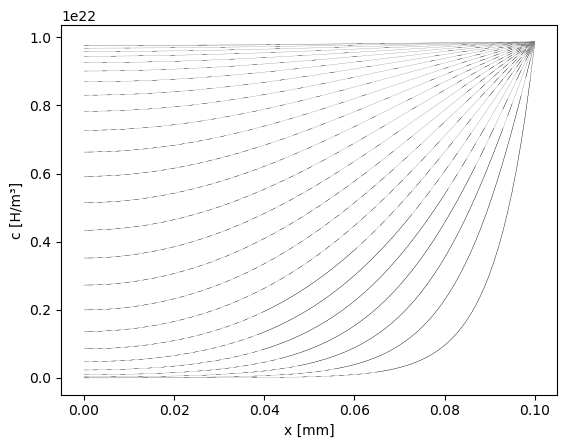

In [11]:
import matplotlib.pyplot as plt

data = np.genfromtxt("task14/solute_spherical.txt", skip_header=1, delimiter=",")
for i in range(1, data.shape[1]):
    plt.plot(data[:, 0]/1e-3, data[:, i], color="tab:grey", linewidth=0.2)

plt.xlabel("x [mm]")
plt.ylabel("c [H/m³]")
plt.show()

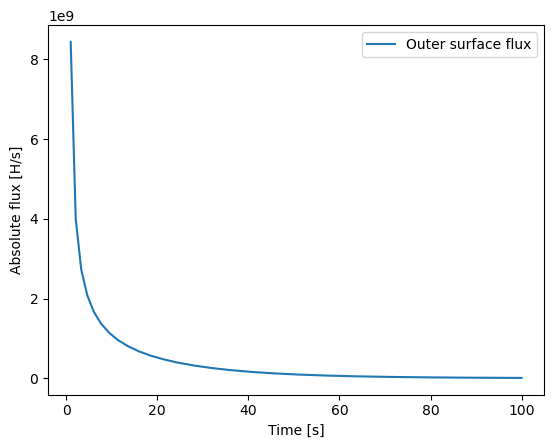

In [13]:
plt.plot(
    derived_quantities[0].t,
    np.abs(derived_quantities[0].data),
    label="Outer surface flux",
)

plt.xlabel("Time [s]")
plt.ylabel("Absolute flux [H/s]")
plt.legend()
plt.show()